In [1]:
# import os
# import numpy as np
# import cv2
# from matplotlib import pyplot as plt
# from keras import backend as K
# from keras.preprocessing import image
# from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions

# import tensorflow as tf
# from tensorflow.python.framework import ops

In [2]:
%matplotlib inline
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
from skimage.transform import resize
from imgaug import augmenters as iaa
from tqdm import tqdm
import PIL
from PIL import Image
import cv2
from sklearn.utils import class_weight, shuffle
import keras_metrics

from keras import backend as K
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions

import tensorflow as tf
from tensorflow.python.framework import ops

import warnings
warnings.filterwarnings("ignore")

/home/watts/anaconda3/envs/hpg/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
def build_model():
    """Function returning keras model instance.
    
    Model can be
     - Trained here
     - Loaded with load_model
     - Loaded from keras.applications
    """
    return VGG16(include_top=True, weights='imagenet')

H, W = 224, 224 # Input shape, defined by the model (model.input_shape)

In [4]:
def load_image(path, preprocess=True):
    """Load and preprocess image."""
    x = image.load_img(path, target_size=(H, W))
    if preprocess:
        x = image.img_to_array(x)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
    return x


def deprocess_image(x):
    """Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    """
    x = x.copy()
    if np.ndim(x) > 3:
        x = np.squeeze(x)
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_dim_ordering() == 'th':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x


def normalize(x):
    """Utility function to normalize a tensor by its L2 norm"""
    return (x + 1e-10) / (K.sqrt(K.mean(K.square(x))) + 1e-10)

In [5]:
def build_guided_model():
    """Function returning modified model.
    
    Changes gradient function for all ReLu activations
    according to Guided Backpropagation.
    """
    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * \
                   tf.cast(op.inputs[0] > 0., dtype)

    g = tf.get_default_graph()
    with g.gradient_override_map({'Relu': 'GuidedBackProp'}):
        new_model = build_model()
    return new_model


def guided_backprop(input_model, images, layer_name):
    """Guided Backpropagation method for visualizing input saliency."""
    input_imgs = input_model.input
    layer_output = input_model.get_layer(layer_name).output
    grads = K.gradients(layer_output, input_imgs)[0]
    backprop_fn = K.function([input_imgs, K.learning_phase()], [grads])
    grads_val = backprop_fn([images, 0])[0]
    return grads_val

In [6]:
def grad_cam(input_model, image, cls, layer_name):
    """GradCAM method for visualizing input saliency."""
    y_c = input_model.output[0, cls]
    print(y_c.shape)
    print(y_c)
    conv_output = input_model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]
    # Normalize if necessary
    # grads = normalize(grads)
    gradient_function = K.function([input_model.input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)

    # Process CAM
    cam = cv2.resize(cam, (H, W), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    return cam

def grad_cam_batch(input_model, images, classes, layer_name):
    """GradCAM method for visualizing input saliency.
    Same as grad_cam but processes multiple images in one run."""
    loss = tf.gather_nd(input_model.output, np.dstack([range(images.shape[0]), classes])[0])
    layer_output = input_model.get_layer(layer_name).output
    grads = K.gradients(loss, layer_output)[0]
    gradient_fn = K.function([input_model.input, K.learning_phase()], [layer_output, grads])

    conv_output, grads_val = gradient_fn([images, 0])    
    weights = np.mean(grads_val, axis=(1, 2))
    cams = np.einsum('ijkl,il->ijk', conv_output, weights)
    
    # Process CAMs
    new_cams = np.empty((images.shape[0], H, W))
    for i in range(new_cams.shape[0]):
        cam_i = cams[i] - cams[i].mean()
        cam_i = (cam_i + 1e-10) / (np.linalg.norm(cam_i, 2) + 1e-10)
        new_cams[i] = cv2.resize(cam_i, (H, W), cv2.INTER_LINEAR)
        new_cams[i] = np.maximum(new_cams[i], 0)
        new_cams[i] = new_cams[i] / new_cams[i].max()
    
    return new_cams

In [7]:
def compute_saliency(model, guided_model, img_path, layer_name='block5_conv3', cls=-1, visualize=True, save=True):
    """Compute saliency using all three approaches.
        -layer_name: layer to compute gradients;
        -cls: class number to localize (-1 for most probable class).
    """
    preprocessed_input = load_image(img_path)

    predictions = model.predict(preprocessed_input)
    top_n = 5
    top = decode_predictions(predictions, top=top_n)[0]
    classes = np.argsort(predictions[0])[-top_n:][::-1]
    print('Model prediction:')
    for c, p in zip(classes, top):
        print('\t{:15s}\t({})\twith probability {:.3f}'.format(p[1], c, p[2]))
    if cls == -1:
        cls = np.argmax(predictions)
    class_name = decode_predictions(np.eye(1, 1000, cls))[0][0][1]
    print("Explanation for '{}'".format(class_name))
    
    gradcam = grad_cam(model, preprocessed_input, cls, layer_name)
    gb = guided_backprop(guided_model, preprocessed_input, layer_name)
    guided_gradcam = gb * gradcam[..., np.newaxis]

    if save:
        jetcam = cv2.applyColorMap(np.uint8(255 * gradcam), cv2.COLORMAP_JET)
        jetcam = (np.float32(jetcam) + load_image(img_path, preprocess=False)) / 2
        cv2.imwrite('../cache/gradcam.jpg', np.uint8(jetcam))
        cv2.imwrite('../cache/guided_backprop.jpg', deprocess_image(gb[0]))
        cv2.imwrite('../cache/guided_gradcam.jpg', deprocess_image(guided_gradcam[0]))
    
    if visualize:
        plt.figure(figsize=(15, 10))
        plt.subplot(131)
        plt.title('GradCAM')
        plt.axis('off')
        plt.imshow(load_image(img_path, preprocess=False))
        plt.imshow(gradcam, cmap='jet', alpha=0.5)

        plt.subplot(132)
        plt.title('Guided Backprop')
        plt.axis('off')
        plt.imshow(np.flip(deprocess_image(gb[0]), -1))
        
        plt.subplot(133)
        plt.title('Guided GradCAM')
        plt.axis('off')
        plt.imshow(np.flip(deprocess_image(guided_gradcam[0]), -1))
        plt.show()
        
    return gradcam, gb, guided_gradcam

In [8]:
model = build_model()
guided_model = build_guided_model()

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [10]:
guided_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

Model prediction:
	boxer          	(242)	with probability 0.420
	bull_mastiff   	(243)	with probability 0.282
	tiger_cat      	(282)	with probability 0.053
	tiger          	(292)	with probability 0.050
	Great_Dane     	(246)	with probability 0.050
Explanation for 'boxer'
()
Tensor("strided_slice:0", shape=(), dtype=float32)


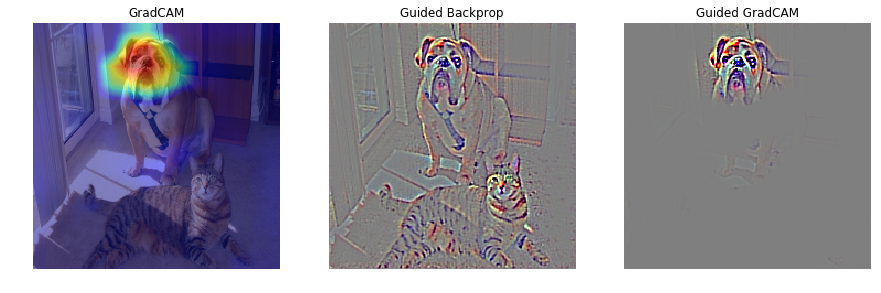

In [11]:
gradcam, gb, guided_gradcam = compute_saliency(model, guided_model, '../cache/gradcam/cat_dog.png', layer_name='block5_conv3', 
                                               cls=-1, visualize=True, save=True)

Model prediction:
	speedboat      	(814)	with probability 0.350
	jellyfish      	(107)	with probability 0.125
	parachute      	(701)	with probability 0.092
	lakeside       	(975)	with probability 0.066
	umbrella       	(879)	with probability 0.024
Explanation for 'speedboat'
()
Tensor("strided_slice_7:0", shape=(), dtype=float32)


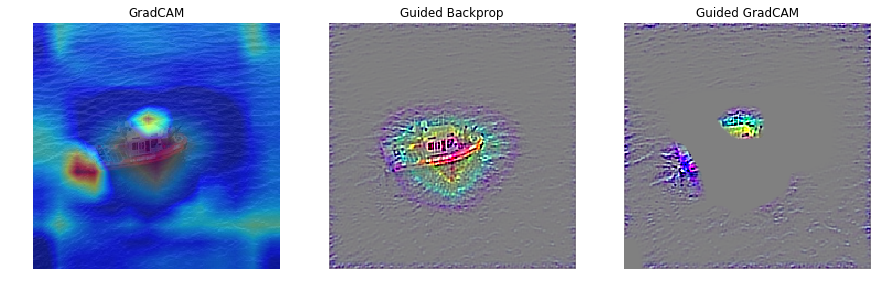

In [28]:
gradcam, gb, guided_gradcam = compute_saliency(model, guided_model, '../cache/gradcam/boat.jpg', layer_name='block5_conv3', 
                                               cls=-1, visualize=True, save=True)

In [12]:
# img = data_generator.load_image(train_dataset_info[1]['path'], (299, 299, 3))

In [13]:
# Load dataset info
path_to_train = '../data/train/'
data = pd.read_csv('../data/train.csv')

In [14]:
train_dataset_info = []
for name, labels in zip(data['Id'], data['Target'].str.split(' ')):
    train_dataset_info.append({
        'path':os.path.join(path_to_train, name),
        'labels':np.array([int(label) for label in labels])})
train_dataset_info = np.array(train_dataset_info)

In [15]:
class data_generator:
    
    def create_train(dataset_info, batch_size, shape, augument=True):
        assert shape[2] == 3
        while True:
            dataset_info = shuffle(dataset_info)
            for start in range(0, len(dataset_info), batch_size):
                end = min(start + batch_size, len(dataset_info))
                batch_images = []
                X_train_batch = dataset_info[start:end]
                batch_labels = np.zeros((len(X_train_batch), 28))
                for i in range(len(X_train_batch)):
                    image = data_generator.load_image(
                        X_train_batch[i]['path'], shape)
#                     image = tdi[i+start]
#                     image = cv2.resize(image, (shape[0], shape[1]))
                    if augument:
                        image = data_generator.augment(image)
                    batch_images.append(image/255.)
                    batch_labels[i][X_train_batch[i]['labels']] = 1
                yield np.array(batch_images, np.float32), batch_labels

    def load_image(path, shape):
        image_red_ch = Image.open(path+'_red.png')
        image_yellow_ch = Image.open(path+'_yellow.png')
        image_green_ch = Image.open(path+'_green.png')
        image_blue_ch = Image.open(path+'_blue.png')
        image1 = np.stack((
            np.array(image_red_ch),
            np.array(image_green_ch), 
            np.array(image_blue_ch)), -1)
        w, h = 512, 512
#         zero_data = np.zeros((h, w), dtype=np.uint8)
#         image2 = np.stack((
#             np.array(image_red_ch),
#             np.array(image_green_ch), 
#             np.array(image_yellow_ch)), -1)
#         image3 = np.stack((
#             np.array(image_yellow_ch),
#             np.array(image_green_ch), 
#             np.array(image_blue_ch)), -1)
# #         print(image1.shape, image2.shape)
#         image = np.vstack((image1, image2, image3))
#         print(image.shape)
        image =image1
#         image = canny_image4(image1)
        image = cv2.resize(image, (shape[0], shape[1]))
        return image
    
    def load_image2(path, shape):
        image_red_ch = Image.open(path+'_red.png')
        image_yellow_ch = Image.open(path+'_yellow.png')
        image_green_ch = Image.open(path+'_green.png')
        image_blue_ch = Image.open(path+'_blue.png')
        image1 = np.stack((
            np.array(image_red_ch),
            np.array(image_green_ch), 
            np.array(image_blue_ch)), -1)
        w, h = 512, 512
#         zero_data = np.zeros((h, w), dtype=np.uint8)
#         image2 = np.stack((
#             np.array(image_red_ch),
#             np.array(image_green_ch), 
#             np.array(image_yellow_ch)), -1)
#         image3 = np.stack((
#             np.array(image_yellow_ch),
#             np.array(image_green_ch), 
#             np.array(image_blue_ch)), -1)
# #         print(image1.shape, image2.shape)
#         image = np.vstack((image1, image2, image3))
#         print(image.shape)
        image =image1
#         image = canny_image4(image1)
        image = cv2.resize(image, (shape[0], shape[1]))
        return image
    
    def augment(image):
        augment_img = iaa.Sequential([
            iaa.OneOf([
                iaa.Affine(rotate=0),
                iaa.Affine(rotate=90),
                iaa.Affine(rotate=180),
                iaa.Affine(rotate=270),
                iaa.Fliplr(0.5),
                iaa.Flipud(0.5),
            ])], random_order=True)

        image_aug = augment_img.augment_image(image)
        return image_aug


In [16]:
img = data_generator.load_image(train_dataset_info[1]['path'], (299, 299, 3))
cv2.imwrite('../cache/img1.png', img)

True

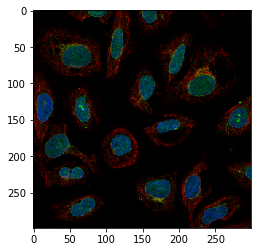

In [17]:
plt.imshow(img)

Model prediction:
	spotlight      	(818)	with probability 0.063
	bubble         	(971)	with probability 0.059
	jellyfish      	(107)	with probability 0.038
	electric_ray   	(5)	with probability 0.032
	lampshade      	(619)	with probability 0.031
Explanation for 'spotlight'
()
Tensor("strided_slice_4:0", shape=(), dtype=float32)


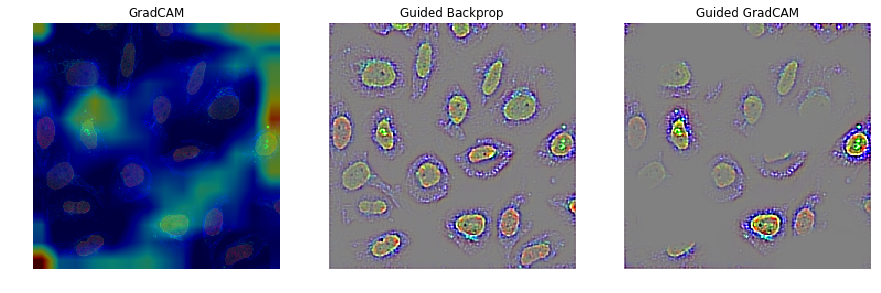

In [23]:
gradcam, gb, guided_gradcam = compute_saliency(model, guided_model, '../cache/img1.png', layer_name='block5_conv3', 
                                               cls=-1, visualize=True, save=True)

In [19]:
model.output

<tf.Tensor 'predictions/Softmax:0' shape=(?, 1000) dtype=float32>

In [21]:
model.output[0, -1]

<tf.Tensor 'strided_slice_3:0' shape=() dtype=float32>